In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('seaborn')
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

# Fix needed to pandas datareader
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

# Collect the data for the google stock 

In [3]:
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2017, 1, 1)

# Need to use iex instead of google
x = web.DataReader("F", 'iex', start, end)
x.head()

5y


,open,high,low,close,volume
date,,,,,
2016-01-04,11.6658,11.7752,11.5649,11.7499,38618524
2016-01-05,11.7499,11.7752,11.3630,11.5396,50267536
2016-01-06,11.4051,11.4051,10.9761,11.0266,61285453
2016-01-07,10.8500,10.9677,10.5976,10.6817,57846688
2016-01-08,10.9761,11.0182,10.5135,10.5472,46199413


In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 5 columns):
open      252 non-null float64
high      252 non-null float64
low       252 non-null float64
close     252 non-null float64
volume    252 non-null int64
dtypes: float64(4), int64(1)
memory usage: 11.8+ KB


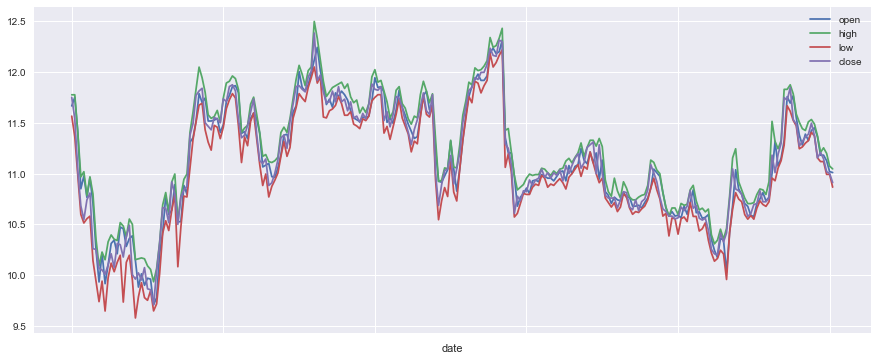

In [5]:
x.drop("volume", axis=1).plot(figsize=(15, 6))
plt.show()

So, we loaded the google stock for one year. Now, we want to predict the High column.

# Create forecasting frame

In [6]:
df_shift, y = make_forecasting_frame(x["high"], kind="price", max_timeshift=20, rolling_direction=1)

In [7]:
df_shift.head()

,time,value,id,kind
4579,2016-01-04,11.7752,2016-01-05,price
4329,2016-01-04,11.7752,2016-01-06,price
4580,2016-01-05,11.7752,2016-01-06,price
4080,2016-01-04,11.7752,2016-01-07,price
4330,2016-01-05,11.7752,2016-01-07,price


In [8]:
df_shift.shape

(4830, 4)

`df_shift` is ready to be passed into the feature extraction process in tsfresh 

In [9]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)

In [10]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(251, 794)
(251, 347)


In [11]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [12]:
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [13]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.75,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
2016-01-06,277.310670,0.0000,0.000000,0.000000,0.000000,11.7519,1.0,0.0348,11.41009,-0.175422,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,11.7752
2016-01-07,407.386976,0.3701,-0.625000,-0.625000,0.140625,11.7519,1.0,0.0348,11.41009,-0.175422,...,1.0,1.0,1.0,1.0,1.0,-101.019783,0.000000,0.0,0.030439,11.4051
2016-01-08,527.677419,0.8075,-0.612852,-0.783745,0.483387,11.7519,1.0,0.0348,11.41009,-0.175422,...,1.0,1.0,1.0,1.0,1.0,-155.236605,0.000000,0.0,0.110586,10.9677
2016-01-11,649.078151,0.8580,-0.558445,-0.804101,0.562109,11.7519,1.0,0.0348,11.41009,-0.175422,...,1.0,1.0,1.0,1.0,1.0,-135.208104,-196.790482,0.0,0.122709,11.0182
2016-01-12,765.344770,1.0935,-0.583303,-0.754325,0.672677,11.7519,1.0,0.0348,11.77520,-1.000000,...,1.0,1.0,1.0,1.0,1.0,-112.489902,-221.171600,0.0,0.153192,10.7827


#  Fit Adaboost

In [14]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████| 150/150 [00:12<00:00, 12.00it/s]


In [15]:
# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

,pred,true
date,,
2016-01-06,NaN,11.4051
2016-01-07,NaN,10.9677
2016-01-08,NaN,11.0182
2016-01-11,NaN,10.7827
2016-01-12,NaN,10.9677


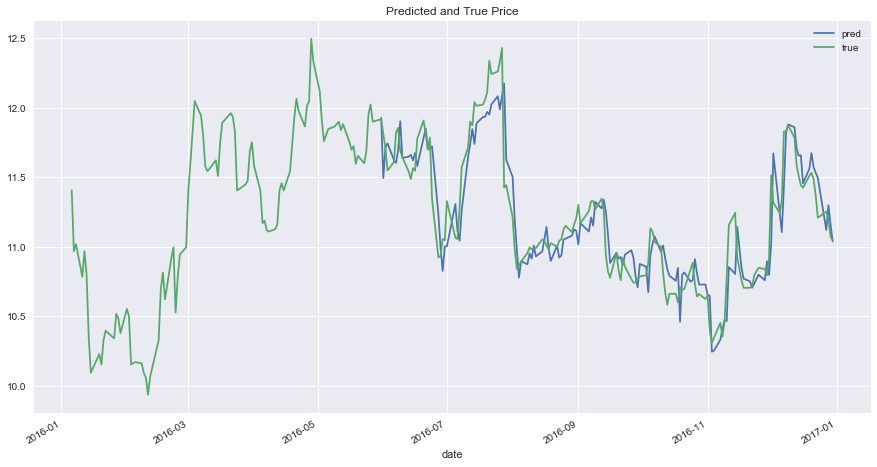

In [16]:
ys.plot(figsize=(15, 8))
plt.title('Predicted and True Price')
plt.show()

Looks not too bad. The green curve is the output of the AdaBoost Regressor, the blue curve is the true High value.

Now, we will also inspect last value before the prediction as a benchmark tool, denoted by y-1

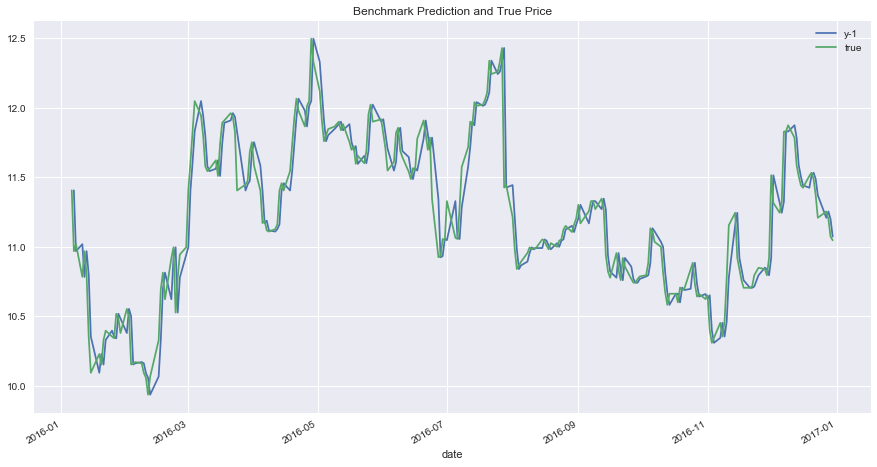

In [17]:
# Create column of previous price
ys['y-1'] = ys['true'].shift(1)
ys[['y-1', 'true']].plot(figsize = (15, 8))
plt.title('Benchmark Prediction and True Price')
plt.show()

In [18]:
print("MAE y-1: \t{}".format(np.mean(np.abs(np.diff(y))[isp-1:] )))
print("MAE ada: \t{}".format(np.mean(np.abs(y_pred - y)[isp:])))

MAE y-1: 	0.10563666666666673
MAE ada: 	0.13985072133402535


However, we are not yet beating the y-1 benchmark, so we need to invest more time into building dedicated features or use a better model.

We can also inspect the relevance of the extracted features

In [19]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(10)

variable
feature_last_value                                                   0.885068
value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4     0.014176
value__fft_coefficient__coeff_9__attr_"real"                         0.006810
value__partial_autocorrelation__lag_5                                0.006574
value__last_location_of_maximum                                      0.006070
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2    0.006022
value__skewness                                                      0.005231
value__mean_change                                                   0.005089
value__autocorrelation__lag_8                                        0.004851
value__time_reversal_asymmetry_statistic__lag_2                      0.004555
dtype: float64

So, the minumum value "feature__maximum" during the last 10 values had the highest importance to predict the next value of the `High` column